# Additional experiments for models from sprints 13-15

We believed that we could improve the accuracy of models from previous 3 sprints, therefore we executed experiments with architectures and hyperparameters that were not tested in the previous sprints. Unlike before, we also display accuracy of the model by comparing true values with predicted values in sprint 14 and 15 experiments.

Architectures and hyperparameters were tested differently compared to the previous sprints - instead of using grid search, we manually changed the model depending on the previous model's results. 

**NOTE**: Most of these experiments were ran as a script and not in a notebook as it was extremely slow, therefore you won't be able to see some printouts in this notebook.

# Sprint 13

The initial experiments with the DNN architecture were found to have two Dropout layers. This has been corrected in the new iteration and experiments were run again. The architecture is similar as in the previous submission.  
On the other hand more experiments were performed with the CNN architecture. During this iteration the following parameters were varied manually:  

* the Conv2D filter sizes 8, 16, 32, 64, 256 in different orders for various layers
* the learning rate was varied between 1e-3 and 3e-4 (these learning rate values have proven to give the best results in the past)
* stride and kernel width were 1, 2, or 3.
* epoch size due to experience from previous iterations was 20 or 500
* batch size was kept to a very small number as it caused ResourceExhaustedError if larger.

The best performing convolutional network architecture ended up having 3 conv2d layers with different kernel widths and pool strides, which improved the result and thus was decided to use for the implementation as well. The exact parameters can be viewed below. The model achieved a loss of 0.116, 97% accuracy and 97% recall on test data.



In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import BatchNormalization, Dense, Conv1D, Conv2D, MaxPool1D, MaxPool2D, Flatten, Dropout, Input, Activation, LSTM, GRU, SimpleRNN, Concatenate, TimeDistributed
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras import backend as K
import glob
from matplotlib import pyplot
from sklearn.metrics import confusion_matrix 

In [ ]:
def plot_metrics(history):
    colors = pyplot.rcParams['axes.prop_cycle'].by_key()['color']
    metrics =  ['loss', 'auc', 'precision', 'recall']
    pyplot.figure(figsize=(10,5))
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        pyplot.subplot(2,2,n+1)
        pyplot.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        pyplot.plot(history.epoch, history.history['val_'+ metric],
             color=colors[0], linestyle="--", label='Val')
        pyplot.xlabel('Epoch')
        pyplot.ylabel(name)
        if metric == 'loss':
            pyplot.ylim([0, pyplot.ylim()[1] +0.1])
        else:
            pyplot.ylim([-0.1,1.1])
        pyplot.legend()

# DNN for Kinect

In [ ]:
# This will store arrays of data from files
features = []
# This will store 1 for good and 0 for wrong(bad)
labels = []

for files in glob.glob('distrib_kinect/*.csv'):
    d = pd.read_csv(str(files)).values
    if 'G' in files or 'A' in files:
        labels.append(1)
    else:
        labels.append(0)
    features.append(d)
    
# Convert them to numpy arrays, cause easier
features = np.array(features)
labels = np.array(labels)

print(features.shape)

# Scale the data
scalers = {}
for i in range(features.shape[1]):
    scalers[i] = StandardScaler()
    features[:, i, :] = scalers[i].fit_transform(features[:, i, :])

for i in range(features.shape[1]):
    features[:, i, :] = scalers[i].transform(features[:, i, :])

(3616, 10, 39)


In [ ]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'),
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
]

In [ ]:
# split data into train, test, val
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

def make_model6():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=x_test[0].shape))
    model.add(tf.keras.layers.Dense(8, activation='tanh'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(Flatten())
    model.add(tf.keras.layers.Dense(64, activation='tanh'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate = 3e-4), metrics = METRICS)
    return model


# construct model
model6 = make_model6()
model6.summary()
                
# compile
es = tf.keras.callbacks.EarlyStopping(monitor='val_auc', verbose=1, patience=10, mode='max', restore_best_weights=True)
# fit model
baseline_history6 = model6.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=500, verbose=0, batch_size=8, callbacks=[es])
baseline_results6 = model6.evaluate(x_test, y_test, batch_size=8, verbose=0)

for name, value in zip(model6.metrics_names, baseline_results6):
    print(name, ': ', value)
print()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10, 8)             320       
_________________________________________________________________
batch_normalization (BatchNo (None, 10, 8)             32        
_________________________________________________________________
flatten (Flatten)            (None, 80)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                5184      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6

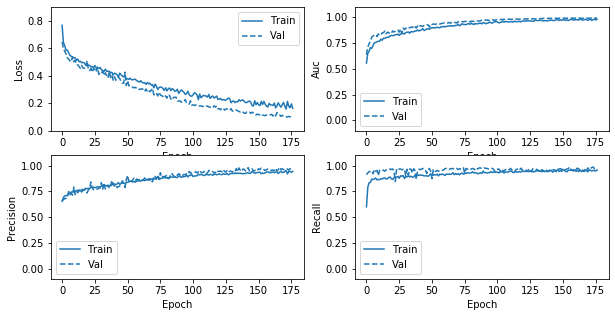

In [ ]:
plot_metrics(baseline_history6)

# Kinect with CNN

In [ ]:
file_dir = os.path.abspath('') # This returns the directory path that this script is in
# This will store arrays of data from files
features = []
# This will store 1 for good and 0 for wrong(bad)
labels = []
for csv_posix in Path(file_dir+'\distrib_kinect').iterdir():
    if csv_posix.suffix != ".csv":
        continue
    # Get the values in a form of an array
    d = pd.read_csv(str(csv_posix)).values
    # Append label to the label array based on file name
    if 'G' in csv_posix.stem or 'A' in csv_posix.stem:
        labels.append(1)
    else:
        labels.append(0)
    features.append(d)

# Convert them to numpy arrays, cause easier
features = np.array(features)
labels = np.array(labels)

# Scale the data
scalers = {}
for i in range(features.shape[1]):
    scalers[i] = StandardScaler()
    features[:, i, :] = scalers[i].fit_transform(features[:, i, :]) 

for i in range(features.shape[1]):
    features[:, i, :] = scalers[i].transform(features[:, i, :]) 

# Reshape
features=features.reshape(features.shape[0],features.shape[1],features.shape[2],1)

In [ ]:
# split data into train, test, val
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'),
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
]

def make_model4():
    model = Sequential()
    model.add(Conv2D(8, (1, 1), activation='tanh', input_shape=x_test[0].shape))
    model.add(MaxPool2D((1, 1), padding='same'))
    model.add(Conv2D(8, (2, 2), activation='tanh'))
    model.add(MaxPool2D((2, 2), padding='same'))
    model.add(Conv2D(16, (3, 3), activation='tanh'))
    model.add(MaxPool2D((3, 3), padding='same'))
    model.add(Flatten())
    #model.add(Dense(16, activation='tanh'))
    model.add(Dense(1, activation='sigmoid'))
    return model

model4 = make_model4()
# check if model params do not exceed 2000
model4.summary()
model4.compile(optimizer=Adam(learning_rate = 3e-4), loss='binary_crossentropy', metrics=METRICS)
es = EarlyStopping(monitor='val_auc', verbose=0, patience=10, mode='max', restore_best_weights=True)
history4 = model4.fit(x_train, y_train, epochs=500, validation_data=(x_val, y_val), verbose=0, batch_size=16, callbacks=[es])
baseline_results4 = model4.evaluate(x_test, y_test, batch_size=16, verbose=0)
                                
for name, value in zip(model4.metrics_names, baseline_results4):
    print(name, ': ', value)
print()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 10, 39, 8)         16        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 39, 8)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 9, 38, 8)          264       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 19, 8)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 17, 16)         1168      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 1, 6, 16)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 96)               

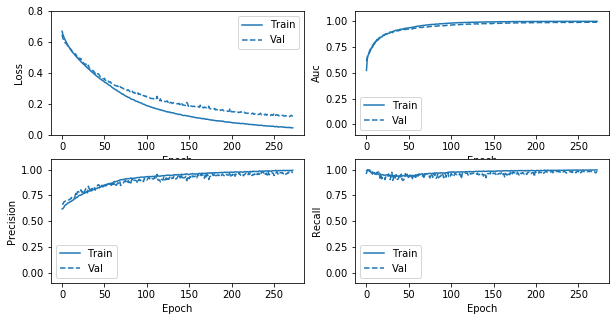

In [ ]:
plot_metrics(history4)

# Sprint 14

We couldn't achieve a good enough accuracy on the test data previously and we believed it to be due to the architecture being too small (too few neurons chosen for the CNN). We also decided to try out a custom loss function for the model fitting to increase efficiency and accuracy.

On the previous attempt to find the best model, we used Conv3D layer as the input for the CNN part of the network was of shape 10x224x224x3. This not only slowed down the experiments immensely, but was not entirely a correct choice. The CNN part of the network deal with 10 frames of each video, but the video itself was 224x224 sized with 3 color channels. This makes the data really a 2D data, therefore Conv2D should have been used wrapped with a TimeDistributed layer to handle time dimension (10 frames).

The following parameters were used for the experiments:
* the number of neurons was chosen to be numbers that are powers of 2 up until 1024
* the learning rate was varied between 1e-3, 3e-4 and 3e-5 (these learning rate values have proven to give the best results in the past)
* stride and kernel width was either 2 or 3
* we tried to keep epoch not higher than a 100 (20, 60, 100)
* batch size was kept to a very small number as it caused ResourceExhaustedError if larger.

The model with the best prediction resulted in 0.041 loss on test data. Below you can also see the graph showing predicted and true points. Most of the predicted points are fairly close to the actual values. The model has improved and can be used in the web-service now.

In [ ]:
def get_split_datasets(data_dir, mark_up_csv, test_size=0.15, random_state=15):
    mark_up = pd.read_csv(mark_up_csv)
    video_names = list(mark_up["video_name"].values)

    label_dir = f"{data_dir}/labels"
    video_label_names = [n.split(".")[0] for n in video_names]
    video_labels = np.array([np.load(f"{label_dir}/{l}.npy") for l in video_label_names])[:, 0]

    train_names, test_names, y_train, y_test = train_test_split(
        video_label_names, video_labels, test_size=test_size,
        random_state=random_state, stratify=video_labels)
    return train_names, test_names


def get_data_by_name(video_name, data_dir):
    frames = np.load(f"{data_dir}/frames/{video_name}.npy")
    numeric_data = np.load(f"{data_dir}/csvs/{video_name}.npy")
    labels = np.load(f"{data_dir}/labels/{video_name}.npy")
    return frames, numeric_data, labels


def get_data_instance(video_name, data_dir, is_augmented=True):
    if is_augmented:
        frames = []
        numeric_data = []
        labels = []
        audmented_names = [p.stem for p in Path(f"{data_dir}/labels/").iterdir() if video_name == p.stem.split("_")[0]]
        for n in audmented_names:
            frm, num_d, lab = get_data_by_name(video_name, data_dir)
            frames.append(frm)
            numeric_data.append(num_d)
            labels.append(lab)
        frames = np.array(frames)
        numeric_data = np.array(numeric_data)
        labels = np.array(labels)
    else:
        frames, numeric_data, labels = get_data_by_name(video_name, data_dir)
        frames = np.array([frames])
        numeric_data = np.array([numeric_data])
        labels = np.array([labels])
    return frames, numeric_data, labels

data_dir = "model_input"
csv_path = "1-180.csv"
train_names, test_names = get_split_datasets(data_dir, csv_path)

# Get validation set names
validation_split = 0.1
slice_indx = int(len(train_names) - len(train_names)*validation_split)
validation_names = train_names[slice_indx:]
train_names = train_names[:slice_indx]

# Get train, validation and test data

train_frames = []
train_numeric = []
train_labels = []

for name in train_names:
    frames, numeric, labels = get_data_instance(name, data_dir)
    for i in range(frames.shape[0]):
        train_frames.append(frames[i])
        train_numeric.append(numeric[i])
        train_labels.append(labels[i])

train_frames = np.array(train_frames)
train_numeric = np.array(train_numeric)
train_labels = np.array(train_labels)

valid_frames = []
valid_numeric = []
valid_labels = []

for name in validation_names:
    frames, numeric, labels = get_data_instance(name, data_dir)
    for i in range(frames.shape[0]):
        valid_frames.append(frames[i])
        valid_numeric.append(numeric[i])
        valid_labels.append(labels[i])

valid_frames = np.array(valid_frames)
valid_numeric = np.array(valid_numeric)
valid_labels = np.array(valid_labels)

test_frames = []
test_numeric = []
test_labels = []

for name in test_names:
    frames, numeric, labels = get_data_instance(name, data_dir, False)
    for i in range(frames.shape[0]):
        test_frames.append(frames[i])
        test_numeric.append(numeric[i])
        test_labels.append(labels[i])

test_frames = np.array(test_frames)
test_numeric = np.array(test_numeric)
test_labels = np.array(test_labels)

# Scale posenet data
scalers = {}
for i in range(train_numeric.shape[1]):
    scalers[i] = StandardScaler()
    train_numeric[:, i, :] = scalers[i].fit_transform(train_numeric[:, i, :])

for i in range(train_numeric.shape[1]):
    train_numeric[:, i, :] = scalers[i].transform(train_numeric[:, i, :])

for i in range(valid_numeric.shape[1]):
    valid_numeric[:, i, :] = scalers[i].transform(valid_numeric[:, i, :])

for i in range(valid_numeric.shape[1]):
    valid_numeric[:, i, :] = scalers[i].transform(valid_numeric[:, i, :])

for i in range(test_numeric.shape[1]):
    test_numeric[:, i, :] = scalers[i].transform(test_numeric[:, i, :])

for i in range(test_numeric.shape[1]):
    test_numeric[:, i, :] = scalers[i].transform(test_numeric[:, i, :])

In [ ]:
# cnn network
def create_a ():
    model = Sequential()
    model.add(Input(shape=train_frames.shape[1:]))
    model.add(TimeDistributed(Conv2D(128, (2, 2),activation='relu')))
    model.add(TimeDistributed(MaxPooling2D(2,2)))
    model.add(TimeDistributed(Conv2D(64, (2, 2), activation='relu')))
    model.add(TimeDistributed(MaxPooling2D(2,2)))
    model.add(TimeDistributed(Conv2D(32, (2, 2), activation='relu')))
    model.add(TimeDistributed(MaxPooling2D(2,2)))
    model.add(TimeDistributed(Flatten()))
    model.add(GRU(256, return_sequences=True))
    model.add(Flatten())
    model.add(Dense(128, activation="relu"))
    return model

# rnn network
def create_b():
    model = Sequential()
    model.add(Input(shape=train_numeric.shape[1:]))
    model.add(GRU(128))
    model.add(Dense(256, activation="relu"))
    model.add(Dense(128, activation="relu"))
    return model

# Normalize score labels
train_labels[:, 0] = train_labels[:, 0] / 5
test_labels[:, 0] = test_labels[:, 0] / 5
valid_labels[:, 0] = valid_labels[:, 0] / 5

In [ ]:
#Custom loss
def cust_loss(y_true, y_pred):
    return K.mean(abs(y_true[0] - y_pred[0]) / 5.0 + abs(y_true[1] - y_pred[1]))

In [ ]:
cnn = create_a()
rnn = create_b()
concat = Concatenate(axis=1)
combined = concat([cnn.output, rnn.output])
dense = Dense(1024, activation="relu")(combined)
dropout = Dropout(0.2)(dense)
output = Dense(2)(dropout)
model = Model([cnn.input, rnn.input], output)
model.compile(loss=cust_loss, optimizer = Adam(lr=1e-3))
es = EarlyStopping(monitor='val_loss', patience=8, verbose=0, restore_best_weights=True)
model.fit([train_frames, train_numeric], train_labels, batch_size=4, epochs=20, callbacks = [es], verbose=0, validation_data=([valid_frames, valid_numeric], valid_labels))
predicted = model.predict([test_frames, test_numeric], batch_size=4)

In [ ]:
plt.rcParams['figure.figsize'] = [15, 5]

## Score prediction accuracy

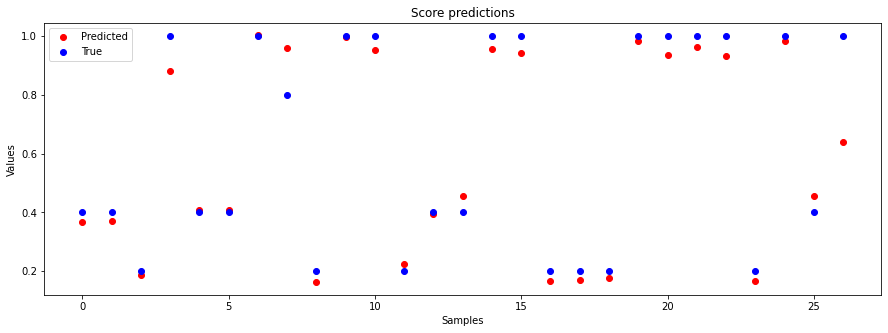

In [ ]:
plt.plot(predicted[:,0], 'ro', label='Predicted')
plt.plot(test_labels[:,0], 'bo', label='True')
plt.legend(loc="upper left")
plt.title('Score predictions')
plt.xlabel('Samples')
plt.ylabel('Values')
plt.show()

## Confidence score prediction accuracy

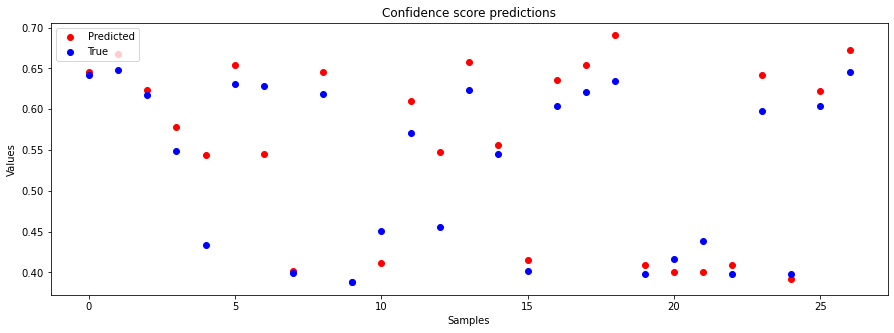

In [ ]:
plt.plot(predicted[:,1], 'ro', label='Predicted')
plt.plot(test_labels[:,1], 'bo', label='True')
plt.legend(loc="upper left")
plt.title('Confidence score predictions')
plt.xlabel('Samples')
plt.ylabel('Values')
plt.show()

# Sprint 15  

We were not satisfied with the results from the previous iteration for sprint 15, and thus decided to re-visit this sprint as well and try out more parameters. The initial idea was to have and architecture where we would have an RNN layer -> Dense or CNN -> Dense or CNN. In the first iteration, similarly as for sprint 13 we did not vary the kernel width and pool strides for the different CNN layers. During this iteration, as we saw the improvement in sprint 13 we tried it for sprint 15 as well. To be more specific:    

The following parameters were used for the experiments:  

* the Conv2D filter sizes 8, 16, 32, 64, 256 in different orders for various layers
* the learning rate was varied between 1e-3 and 3e-4 (these learning rate values have proven to give the best results in the past)
* stride and kernel width were 1, 2, or 3.  
* epoch size due to experience from previous iterations was 20 or 500  
* batch size was kept to a very small number as it caused ResourceExhaustedError if larger.  

The best performing convolutional network architecture ended up having 2 conv1d layers with different kernel widths and pool strides, which improved the result. The exact parameters can be viewed below. The model achieved a loss of 0.294.  

Moreover, in the second iteration, other architectures were tried out as well. For example, an architecture with only dense layers or with only convolutional layers, however, the best performing architecture with these non-mixed layers was an recurrent neural network consisting of 3 GRU layers with different units. This architecture is also used for the implementation as it has the best result. The model here achieved a loss of 0.292.

In [ ]:
def get_split_datasets(data_dir, test_size=0.15, random_state=15):
    all_names = [f.stem.split("_")[0] for f in Path(f"{data_dir}").iterdir()]
    files = set(all_names)
    names = list(files)
    labels = np.zeros(len(names))

    train_names, test_names, y_train, y_test = train_test_split(
        names, labels, test_size=test_size,
        random_state=random_state)
    return train_names, test_names

def get_data_by_name(video_name, data_dir):
    return np.load(f"{data_dir}/{video_name}.npy", allow_pickle=True)

def get_data_instance(video_name, labels, data_dir, is_augmented=True, is_kinect = True):
    if is_augmented:
        data = []
        labels = []
        audmented_names = [p.stem for p in Path(f"{data_dir}").iterdir() if video_name == p.stem.split("_")[0]]
        for n in audmented_names:
            if is_kinect:
                d = get_data_by_name(video_name+"_kinect", data_dir)
            else:
                d = get_data_by_name(video_name, data_dir)
            data.append(d[0])
            labels.append(d[1])
        data = np.array(data)
        labels = np.array(labels)
    else:
        if is_kinect:
            d = get_data_by_name(video_name+"_kinect", data_dir)
        else:
            d = get_data_by_name(video_name, data_dir)
        data = np.array([d[0]])
        labels = d[1]
    return data, labels

data_dir = "kinect_input_data"
is_kinect = True
labels = "scores.csv"
train_names, test_names = get_split_datasets(data_dir)

#Get validation set names
validation_split = 0.1
slice_indx = int(len(train_names) - len(train_names)*validation_split)
validation_names = train_names[slice_indx:]
train_names = train_names[:slice_indx]

# Get data
train_features = []
train_labels = []

test_features = []
test_labels = []

val_features = []
val_labels = []

for name in train_names:
    data, labels = get_data_instance(name, labels, data_dir, True, is_kinect)
    for i in range(data.shape[0]):
        train_features.append(data[i])
    for i in range(labels.shape[0]):
        train_labels.append(labels[i])

train_features = np.array(train_features)
train_labels = np.array(train_labels)

for name in test_names:
    data, labels = get_data_instance(name, labels, data_dir, False, is_kinect)
    for i in range(data.shape[0]):
        test_features.append(data[i])
    test_labels.append(labels)

test_features = np.array(test_features)
test_labels = np.array(test_labels)

for name in validation_names:
    data, labels = get_data_instance(name, labels, data_dir, True, is_kinect)
    for i in range(data.shape[0]):
        val_features.append(data[i])
    for i in range(labels.shape[0]):
        val_labels.append(labels[i])

val_features = np.array(val_features)
val_labels = np.array(val_labels)

# Scale data

#Features
scalers = {}
for i in range(train_features.shape[1]):
    scalers[i] = StandardScaler()
    train_features[:, i, :] = scalers[i].fit_transform(train_features[:, i, :])

for i in range(train_features.shape[1]):
    train_features[:, i, :] = scalers[i].transform(train_features[:, i, :])

for i in range(val_features.shape[1]):
    val_features[:, i, :] = scalers[i].transform(val_features[:, i, :])

for i in range(val_features.shape[1]):
    val_features[:, i, :] = scalers[i].transform(val_features[:, i, :])

for i in range(test_features.shape[1]):
    test_features[:, i, :] = scalers[i].transform(test_features[:, i, :])

for i in range(test_features.shape[1]):
    test_features[:, i, :] = scalers[i].transform(test_features[:, i, :])

#Labels
scaler = StandardScaler()
train_labels = scaler.fit_transform(train_labels)
val_labels = scaler.transform(val_labels)
test_labels = scaler.transform(test_labels)

In [ ]:
plt.rcParams['figure.figsize'] = [15, 5]

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_33 (GRU)                 (None, 20, 64)            20160     
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 20, 8)             1544      
_________________________________________________________________
max_pooling1d_24 (MaxPooling (None, 6, 8)              0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 6, 8)              136       
_________________________________________________________________
max_pooling1d_25 (MaxPooling (None, 3, 8)              0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 24)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 512)             

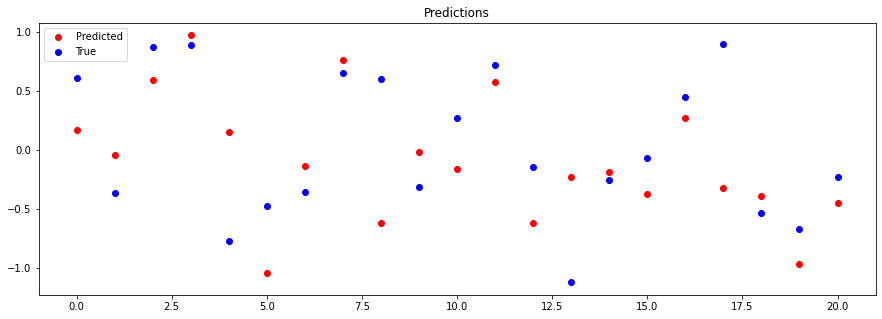

In [ ]:
def make_model():
    model = Sequential()
    model.add(GRU(64, input_shape=train_features.shape[1:], return_sequences=True))
    model.add(Conv1D(8, (3), padding="same", activation="relu"))
    model.add(MaxPooling1D(3))
    model.add(Conv1D(8, (2), padding="same", activation="relu"))
    model.add(MaxPooling1D(2))
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    return model

model = make_model()
model.summary()
model.compile(loss='mean_absolute_error', optimizer = Adam(1e-3))
es = EarlyStopping(monitor='val_loss', patience=10, verbose=0, restore_best_weights=True)
model.fit(train_features, train_labels, batch_size=16, epochs=60, callbacks = [es], verbose=0, validation_data=(val_features, val_labels))
baseline_results = model.evaluate(test_features, test_labels)

predicted = model.predict(test_features, batch_size=16)

plt.plot(predicted, 'ro', label='Predicted')
plt.plot(test_labels, 'bo', label='True')
plt.legend(loc="upper left")
plt.title('Predictions')
plt.show()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_30 (GRU)                 (None, 20, 64)            20160     
_________________________________________________________________
gru_31 (GRU)                 (None, 20, 32)            9408      
_________________________________________________________________
gru_32 (GRU)                 (None, 20, 8)             1008      
_________________________________________________________________
flatten_18 (Flatten)         (None, 160)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 161       
Total params: 30,737
Trainable params: 30,737
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 0s 1ms/step - loss: 0.2929


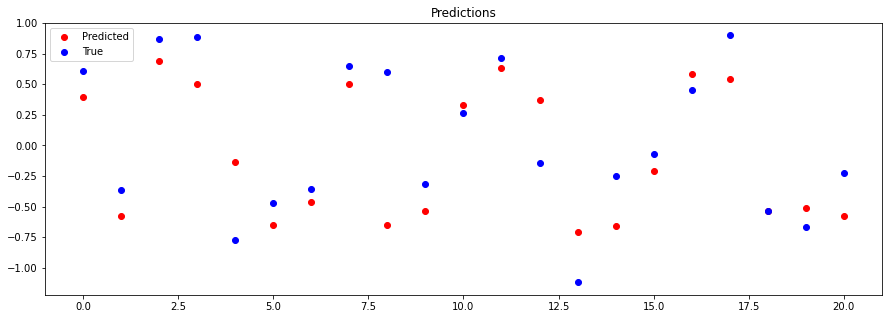

In [ ]:
def make_model2():
    model = Sequential()
    model.add(Input(shape=train_features.shape[1:]))
    model.add(GRU(64, return_sequences=True))
    model.add(GRU(32, return_sequences=True))
    model.add(GRU(8, return_sequences=True))
    model.add(Flatten())
    model.add(Dense(1))
    return model

model2 = make_model2()
model2.summary()
model2.compile(loss='mean_absolute_error', optimizer = Adam(1e-3))
es = EarlyStopping(monitor='val_loss', patience=10, verbose=0, restore_best_weights=True)
model2.fit(train_features, train_labels, batch_size=8, epochs=60, callbacks = [es], verbose=0, validation_data=(val_features, val_labels))
baseline_results2 = model2.evaluate(test_features, test_labels)

predicted2 = model2.predict(test_features, batch_size=8)

plt.plot(predicted2, 'ro', label='Predicted')
plt.plot(test_labels, 'bo', label='True')
plt.legend(loc="upper left")
plt.title('Predictions')
plt.show()